In [1]:
import numpy as np
import numpy.linalg as linalg
import sys

from math import sqrt

from mltools.kmeans import KMeans, KMeansMahalanobis

In [2]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

In [3]:
X_iris, Y_iris = datasets.load_iris(return_X_y=True)

In [4]:
from sklearn.decomposition import PCA

In [5]:
pca = PCA(n_components=2)
pca.fit(X_iris)
X = pca.transform(X_iris)
Y = Y_iris

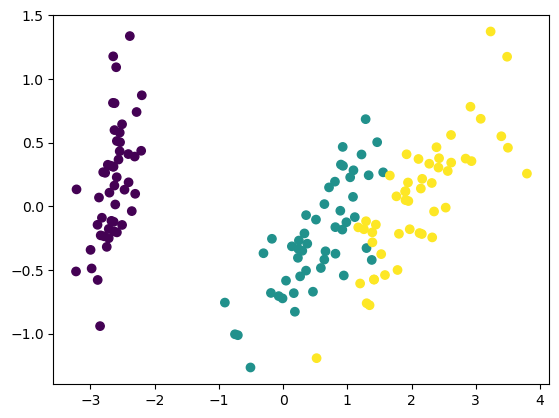

In [6]:
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [7]:
XX, YY = np.meshgrid(np.linspace(-4,4,100), np.linspace(-4,4,100))
XY = np.c_[(XX.ravel(), YY.ravel())]

In [8]:
km = KMeans(3)

In [9]:
km.fit(X)

2.089791276817546
0.605681727802451
0.1416476142283507
0.043064763209316875
0.09265825404102843
0.0


In [10]:
print(km.K)
print(km.c)

6
[[ 0.66567601 -0.3316042 ]
 [-2.64241546  0.19088505]
 [ 2.34652659  0.27393856]]


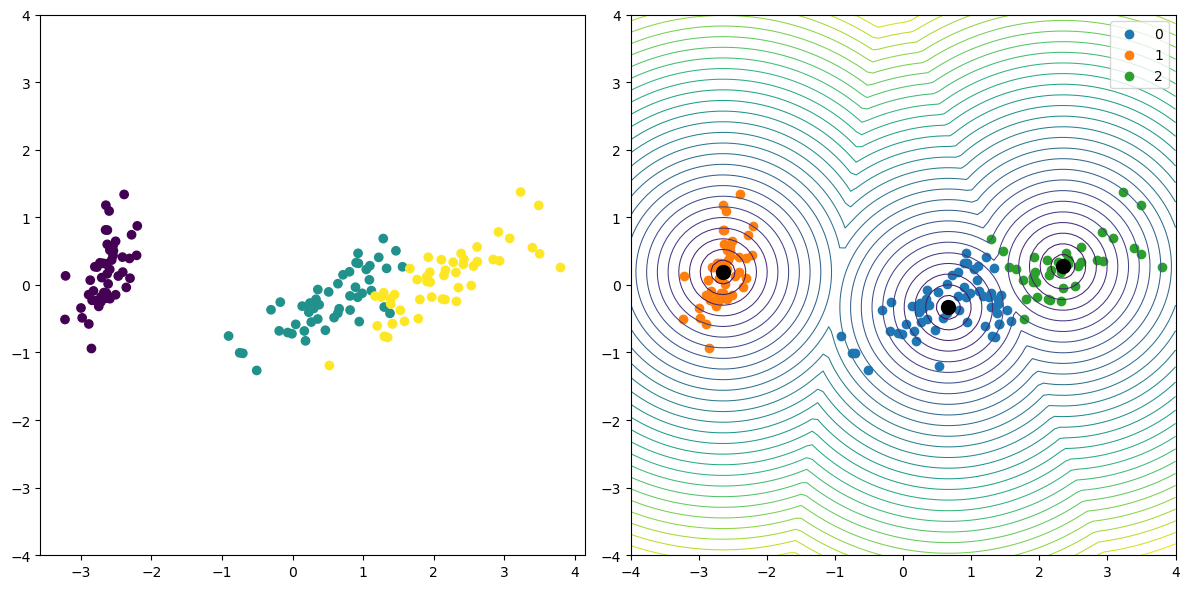

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.ylim(-4,4)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.subplot(1,2,2)
for j, Ij in enumerate(km.Is):
    Xj = X[Ij]
    plt.scatter(Xj[:,0], Xj[:,1], label=str(j))
plt.scatter(km.c[:,0], km.c[:,1], c='k', s=100)

Z = np.fromiter((km.dist(xy) for xy in XY), 'd', len(XY))
ZZ = Z.reshape(XX.shape)
plt.contour(ZZ, levels=np.linspace(Z.min(), Z.max(), 30), extent=(-4,4,-4,4), linewidths=0.75)

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
kmm = KMeansMahalanobis(3)

In [13]:
kmm.fit(X)

In [14]:
print(kmm.K)
print(kmm.c)
print(kmm.S1)

1
[[-2.64241546  0.19088505]
 [ 2.34652659  0.27393856]
 [ 0.66567601 -0.3316042 ]]
[array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]])]


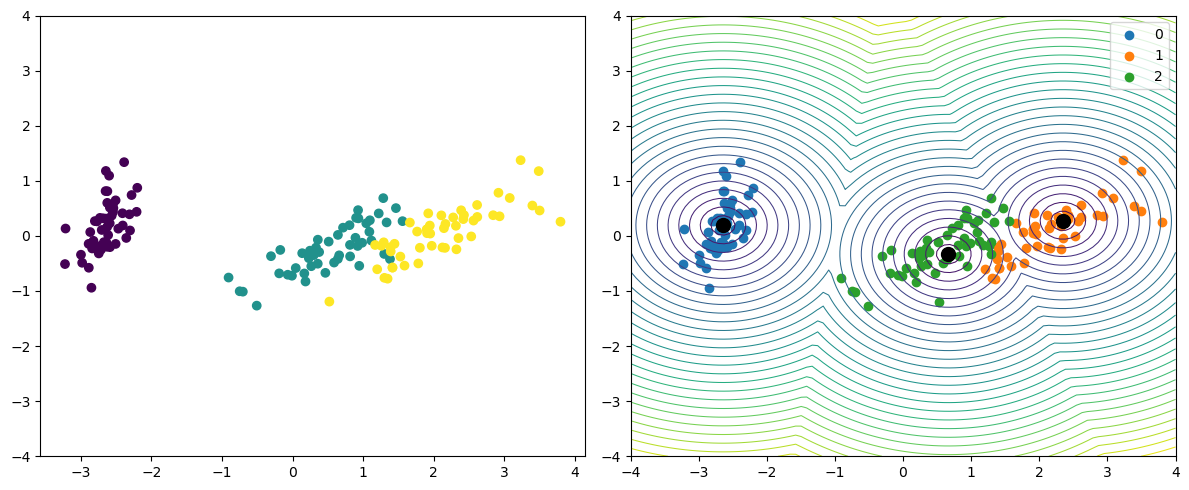

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.ylim(-4,4)
plt.subplot(1,2,2)
for j, Ij in enumerate(kmm.Is):
    Xj = X[Ij]
    plt.scatter(Xj[:,0], Xj[:,1], label=str(j))
plt.scatter(kmm.c[:,0], kmm.c[:,1], c='k', s=100)

Z = np.fromiter((kmm.dist(xy) for xy in XY), 'd', len(XY))
ZZ = Z.reshape(XX.shape)
plt.contour(ZZ, levels=np.linspace(Z.min(), Z.max(), 30), extent=(-4,4,-4,4), linewidths=0.75)

plt.legend()
plt.tight_layout()
plt.show()